[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

#  Polynomial Fit with RANSAC

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 24/03/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0049RegressorRobust.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.linear_model import HuberRegressor, LinearRegression ,RANSACRegressor

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [4]:
# Courses Packages

import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotRegressionData


In [5]:
# General Auxiliary Functions

def GenOutlierData( vR: np.ndarray, vO: np.ndarray, vI: np.ndarray, numOutliers: int ) -> np.ndarray:

    vY = vR.copy()
    vY[vI[:numOutliers]] = vO[vI[:numOutliers]]

    return vY

def PlotPolyFit( vX: np.ndarray, vR: np.ndarray, vO: np.ndarray, vI: np.ndarray, numOutliers: int, P: int, minSamplesRatio: float, 
                numGridPts: int = 1001, hA: Optional[plt.Axes] = None, figSize: Tuple[int, int] = FIG_SIZE_DEF, markerSize: int = MARKER_SIZE_DEF, 
                lineWidth: int = LINE_WIDTH_DEF, axisTitle: Optional[str] = None ) -> None:

    if hA is None:
        hF, hA = plt.subplots(1, 1, figsize = figSize)
    else:
        hF = hA[0].get_figure()

    numSamples = len(vX)

    mX = vX[:, np.newaxis] ** range(P + 1)
    vY = GenOutlierData(vR, vO, vI, numOutliers)

    oLinReg = LinearRegression(fit_intercept = False).fit(mX, vY)
    oRanReg = RANSACRegressor(estimator = LinearRegression(fit_intercept = False), min_samples = minSamplesRatio).fit(mX, vY)
    oHubReg = HuberRegressor(fit_intercept = False).fit(mX, vY)

    #TODO: Add calculation of the R2 only on the inliers

    # Plot
    xx  = np.linspace(np.floor(np.min(vX)), np.ceil(np.max(vX)), numGridPts)
    yy1 = np.polyval(oLinReg.coef_[::-1], xx)
    yy2 = np.polyval(oRanReg.estimator_.coef_[::-1], xx)
    yy3 = np.polyval(oHubReg.coef_[::-1], xx)

    hA.plot(vX, vY, '.r', ms = markerSize, label = '$y_i$')
    hA.plot(vX[vI[:numOutliers]], vY[vI[:numOutliers]], '.y', ms = markerSize, label = 'Outliers')
    hA.plot(xx, yy1, 'g', lw = 2,  label = f'OLS, R2 = {oLinReg.score(mX, vY)}')
    hA.plot(xx, yy2, 'b', lw = 2,  label = f'RANSAC, R2 = {oRanReg.estimator_.score(mX, vY)}')
    hA.plot(xx, yy3, 'm', lw = 2,  label = f'Huber, R2 = {oHubReg.score(mX, vY)}')
    hA.set_title (f'OLS vs. RANSAC OLS vs. Huber Loss')
    hA.set_xlabel('$x$')
    hA.set_ylabel('$y$')
    hA.grid()
    hA.legend()


## Robust Regression

The concept of _Robust Regression_ is to estimate the model parameters while minimizing the effect of the _outliers_.  
It is usually achieved by 2 approaches:

1. Robust Objective  
   Using an outlier robust objective function. Such as the ${L}^{1}$ or [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss).
2. Filtration  
   Marking the _outliers_ and applying the objective on the _inliers_.

* <font color='brown'>(**#**)</font> RANSAC is a filtration approach which iteratively finds the inliers of the data.

In [6]:
# Parameters

# Data Generation
numSamples  = 150
noiseStd    = 0.3
numOutliers = 30
fctOutliers = 5

vP = np.array([1, 2])

# Data Visualization
gridNoiseStd    = 0.05
numGridPts      = 500

## Generate / Load Data

$$ y_{i} = f \left( x_{i} \right) + \epsilon_{i} $$

Where

$$ f \left( x \right) = \sum_{i = 0}^{N - 1} {p}_{i} {x}^{N - 1 - i} $$


In [7]:
# The Data Generating Function

def f( vX: np.ndarray, vP: np.ndarray ) -> np.ndarray:
    
    return np.polyval(vP, vX)

hF = lambda vX: f(vX, vP)

In [8]:
# Generate Data

vX = np.linspace(-2, 2, numSamples, endpoint = True) + (gridNoiseStd * np.random.randn(numSamples))
vN = noiseStd * np.random.randn(numSamples)
vR = f(vX, vP) + vN
vO = fctOutliers * vR
vI = np.random.permutation(numSamples)
vY = GenOutlierData(vR, vO, vI, numOutliers)

print(f'The features data shape: {vX.shape}')
print(f'The labels data shape: {vY.shape}')

The features data shape: (150,)
The labels data shape: (150,)


### Plot Data

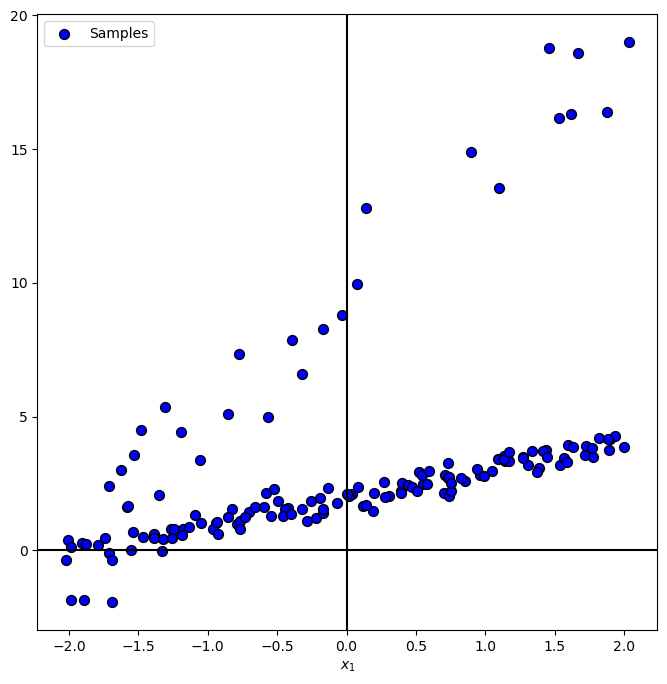

In [9]:
# Plot the Data

PlotRegressionData(vX, vY)

plt.show()


## Train a Robust Polyfit Regressor

The _Linear Regressor_ optimization problem is given by:

$$ \arg \min_{\boldsymbol{w}} \frac{1}{2} {\left\| X \boldsymbol{w} - \boldsymbol{y} \right\|}_{2}^{2} $$

Where in Polynomial model:

$$
\boldsymbol{X} = \begin{bmatrix} 1 & x_{1} & x_{1}^{2} & \cdots & x_{1}^{p} \\
1 & x_{2} & x_{2}^{2} & \cdots & x_{2}^{p} \\
\vdots & \vdots & \vdots &  & \vdots \\
1 & x_{N} & x_{N}^{2} & \cdots & x_{N}^{p}
\end{bmatrix}
$$

There are 2 robust model to train:

1. Huber Loss  
   Being based on a _Robust Loss_.  
   Implemented by [`HuberRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html).
2. RANSAC
   Filtration of outliers by maximizing the number of _inliers_.
   Implemented by [`RANSACRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html).  
   The model `estimator` parameter supports any regressor with the `fit()`, `predict()` and `score()` methods.

* <font color='brown'>(**#**)</font> Linear model can work with any features with transformation (Polynomial or not).
* <font color='brown'>(**#**)</font> In practice the _RANSAC_ method can be used for any model, _Linear_ or _Non Linear_.

In [10]:
# Interactive Plot

hPolyFit = lambda numOutliers, minSamplesRatio: PlotPolyFit(vX, vR, vO, vI, numOutliers, len(vP) - 1, minSamplesRatio)
numOutliersSlider = IntSlider(min = 0, max = numSamples, step = 1, value = 0, layout = Layout(width = '30%'))
minSamplesRatioSlider = FloatSlider(min = 0.01, max = 1.0, step = 0.01, value = 0.5, layout = Layout(width = '30%'))
interact(hPolyFit, numOutliers = numOutliersSlider, minSamplesRatio = minSamplesRatioSlider)
plt.show()

interactive(children=(IntSlider(value=0, description='numOutliers', layout=Layout(width='30%'), max=150), Floa…

* <font color='red'>(**?**)</font> Does the _R2_ score reflects the performance? What can be done?
* <font color='brown'>(**#**)</font> Once we have the model we may even use it to identify the outliers (Outlier / Anomaly Detection).

R2 score examples:

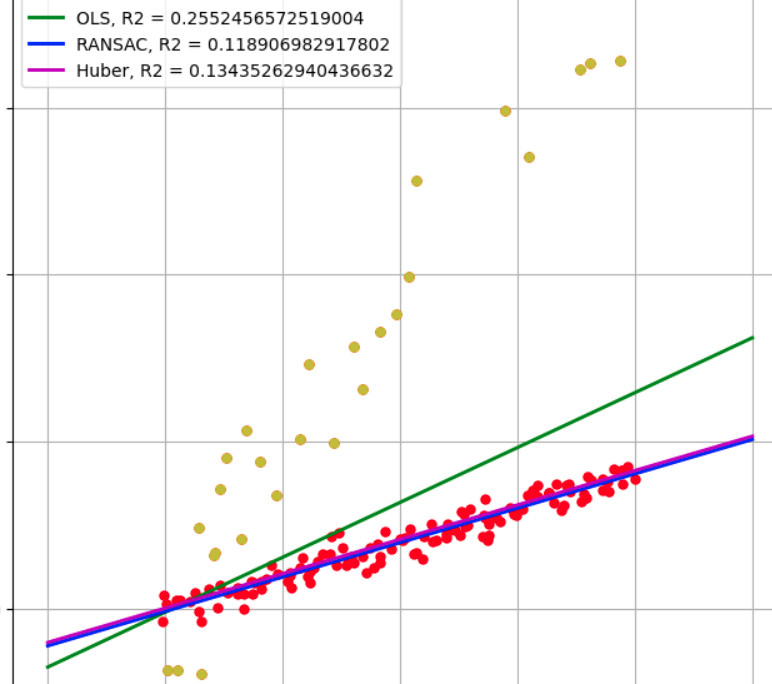